In [1]:
import pandas as pd

# i numeri li voglio vedere con due cifre decimali
pd.set_option('display.float_format', lambda x: '{0:.2f}'.format(x))

df = pd.read_csv("storico_prestiti.csv")
df.head()

,importo,livello,durata,tipologia,saldo,eta,estinto
0,1000,B,2.00,Elettrodomestici,375.92,24,0
1,6500,A,2.00,Autovettura,1530.26,28,1
2,2400,A,2.00,Elettrodomestici,1382.27,36,0
3,10000,C,3.00,Elettrodomestici,1431.60,24,0
4,4000,C,2.00,Elettrodomestici,395.65,28,1


In [2]:
df.describe()

,importo,durata,saldo,eta,estinto
count,7727.00,7448.00,7727.00,7727.00,7727.00
mean,9453.35,6.09,1465.44,27.54,0.48
std,6298.60,6.70,1156.12,6.13,0.50
min,500.00,0.00,1.00,20.00,0.00
25%,5000.00,2.00,814.96,23.00,0.00
50%,8000.00,4.00,1234.28,26.00,0.00
75%,12000.00,8.00,1796.57,30.00,1.00
max,35000.00,62.00,29501.00,94.00,1.00


In [3]:
df.isnull().sum()

importo        0
livello        0
durata       279
tipologia      0
saldo          0
eta            0
estinto        0
dtype: int64

In [4]:
import numpy as np

df.durata = df.durata.fillna(np.mean(df.durata))
pd.unique(df.durata)

array([  2.       ,   3.       ,   1.       ,   6.       ,   4.       ,
         0.       ,  16.       ,  12.       ,  11.       ,  15.       ,
         6.0863319,  18.       ,   8.       ,   7.       ,  34.       ,
         9.       ,  14.       ,   5.       ,  10.       ,  20.       ,
        26.       ,  19.       ,  24.       ,  61.       ,  27.       ,
        21.       ,  13.       ,  30.       ,  23.       ,  22.       ,
        31.       ,  25.       ,  17.       ,  38.       ,  28.       ,
        29.       ,  56.       ,  47.       ,  45.       ,  43.       ,
        32.       ,  33.       ,  36.       ,  40.       ,  44.       ,
        53.       ,  41.       ,  55.       ,  62.       ,  48.       ,
        37.       ,  35.       ])

In [5]:
df.dtypes

importo        int64
livello       object
durata       float64
tipologia     object
saldo        float64
eta            int64
estinto        int64
dtype: object

In [6]:
df['livello'].unique()

array(['B', 'A', 'C', 'D', 'E', 'F', 'G'], dtype=object)

In [7]:
df['tipologia'].unique()

array(['Elettrodomestici', 'Autovettura', 'Elettronica', 'Altro'], dtype=object)

In [8]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

le_livello = LabelEncoder()
le_livello = le_livello.fit(df["livello"])
df_encoded.livello = le_livello.transform(df.livello)
 
le_tipologia = LabelEncoder()
le_tipologia = le_tipologia.fit(df["tipologia"])
df_encoded.tipologia = le_tipologia.transform(df.tipologia)
 
df_encoded.head()

,importo,livello,durata,tipologia,saldo,eta,estinto
0,1000,1,2.00,2,375.92,24,0
1,6500,0,2.00,1,1530.26,28,1
2,2400,0,2.00,2,1382.27,36,0
3,10000,2,3.00,2,1431.60,24,0
4,4000,2,2.00,2,395.65,28,1


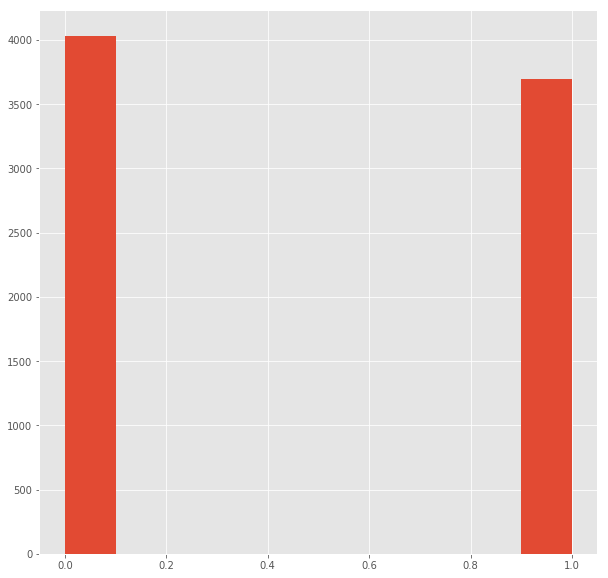

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

# seleziono uno stile più carino rispetto a quello classico
plt.style.use('ggplot')

plt.hist(df.estinto)
plt.savefig("rf1.png")

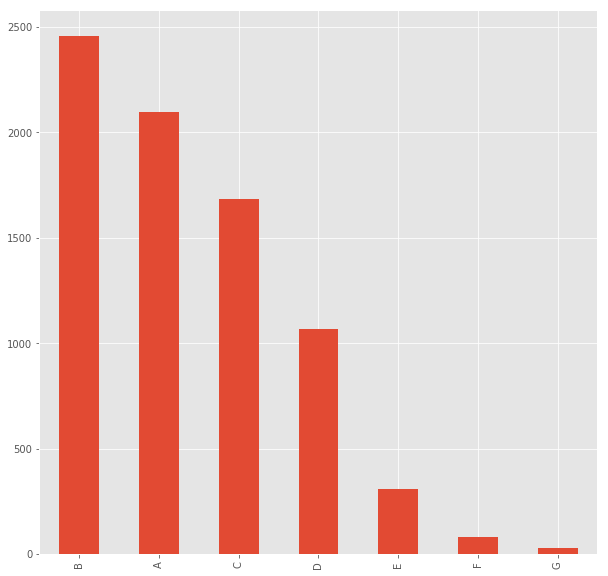

In [10]:
conteggio = df.livello.value_counts()

# piccola scorciatoia: uso Pandas per fare il grafico!!
conteggio.plot.bar()
plt.savefig("rf2.png")

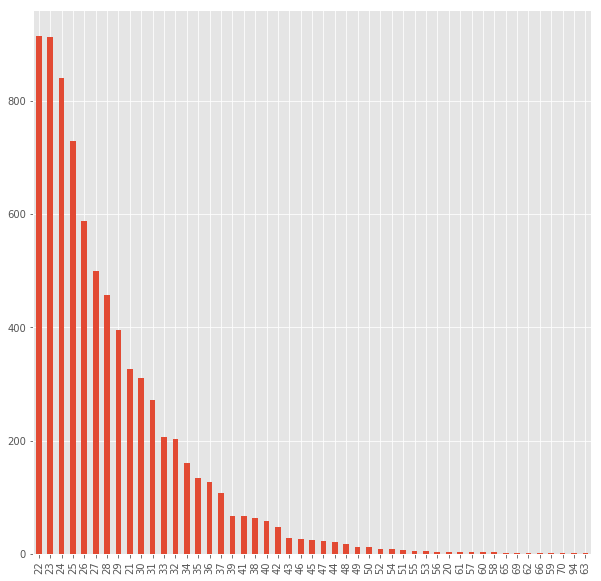

In [11]:
conteggio = df.eta.value_counts()
conteggio.plot.bar()
plt.savefig("rf3.png")

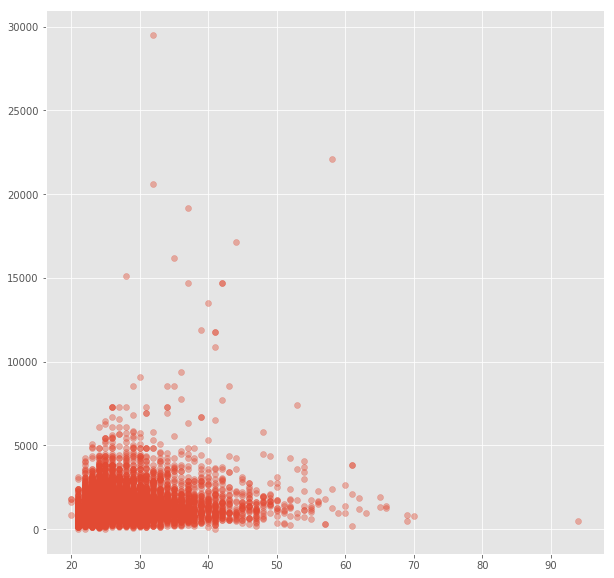

In [12]:
plt.scatter(df.eta, df.saldo, alpha=0.4)
plt.savefig("rf4.png")

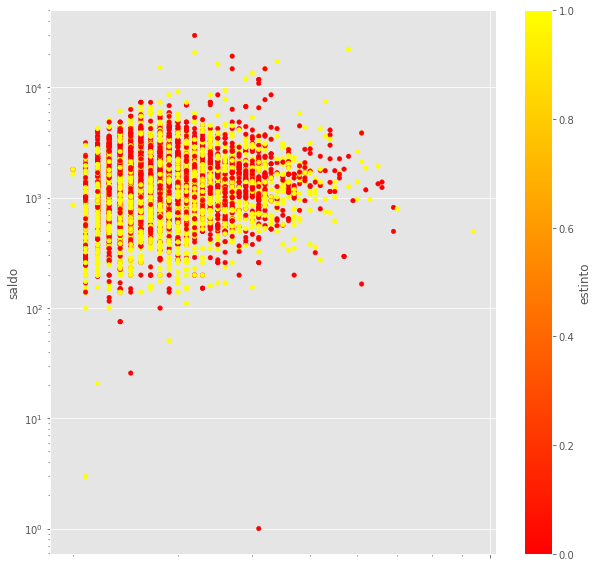

In [13]:
df.plot.scatter(
    x='eta', 
    y='saldo', 
    c='estinto', 
    logx=True, logy=True, 
    cmap='autumn'
)
plt.savefig("rf5.png")

In [14]:
from sklearn import tree
X_2 = df_encoded.loc[:,('eta', 'saldo')]
y = df_encoded.loc[:,'estinto']

clf_dt = tree.DecisionTreeClassifier(max_depth=2)
clf_dt = clf_dt.fit(X_2, y)

In [15]:
print(clf_dt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [16]:
import pydotplus 
dot_data = tree.export_graphviz(clf_dt, out_file='tree_3.dot', feature_names=X_2.columns,
                                class_names=['no', 'yes'], filled=True, 
                                rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_file('tree_3.dot')

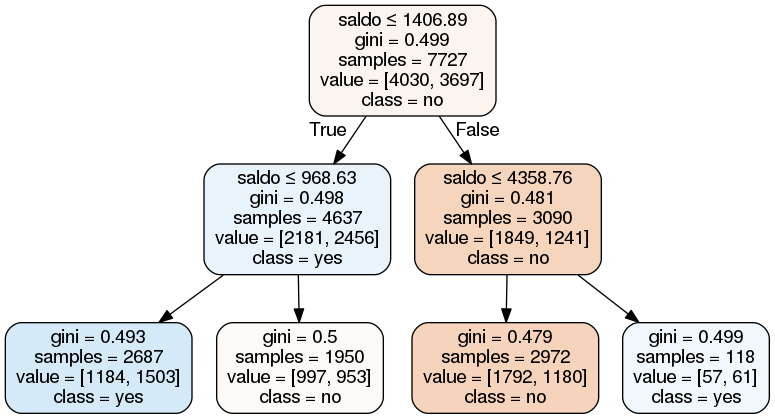

In [17]:
from IPython.display import Image
Image(graph.create_png())

In [18]:
def plot_boundaries(X2, clf, filename):
    x_min, x_max = X2.iloc[:, 0].min() - 1, X2.iloc[:, 0].max() + 1
    y_min, y_max = X2.iloc[:, 1].min() - 1, X2.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)/100), 
                         np.arange(y_min, y_max, (y_max - y_min)/100))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    target = clf.predict(X2)
    plt.scatter(
        x = X2.iloc[:,0], 
        y = X2.iloc[:,1], 
        c = y, 
        s = 20,  
        cmap=plt.cm.magma)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha = 0.4)
    plt.savefig(filename)

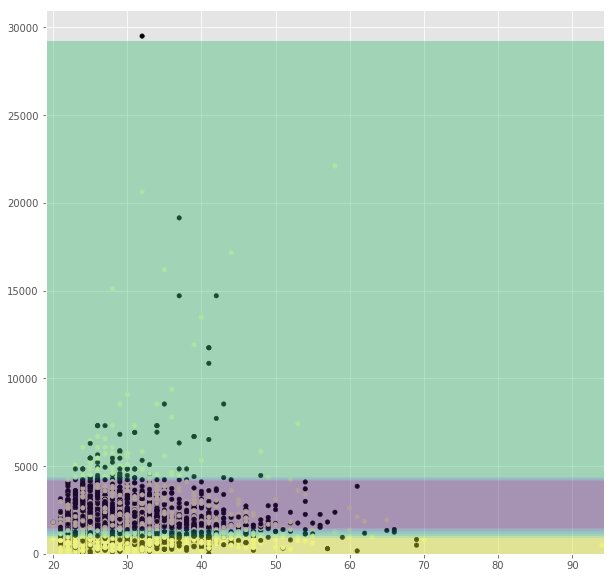

In [19]:
plot_boundaries(X_2, clf_dt, "rf6.png")

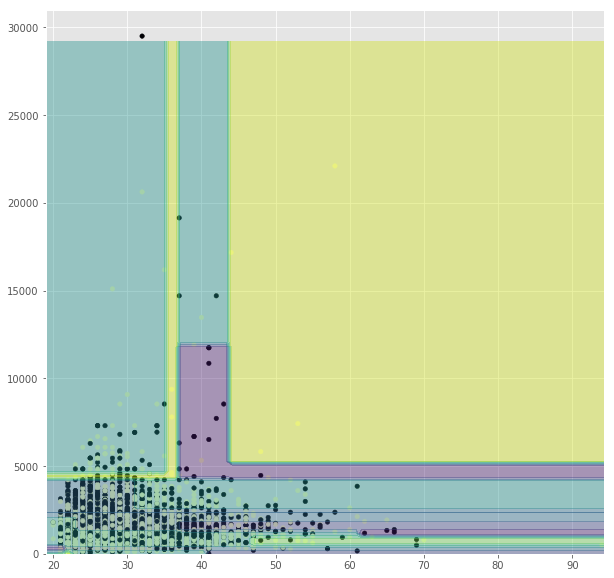

In [20]:
clf_dt_5 = tree.DecisionTreeClassifier(max_depth=5).fit(X_2,y)
plot_boundaries(X_2, clf_dt_5, "rf7.png")

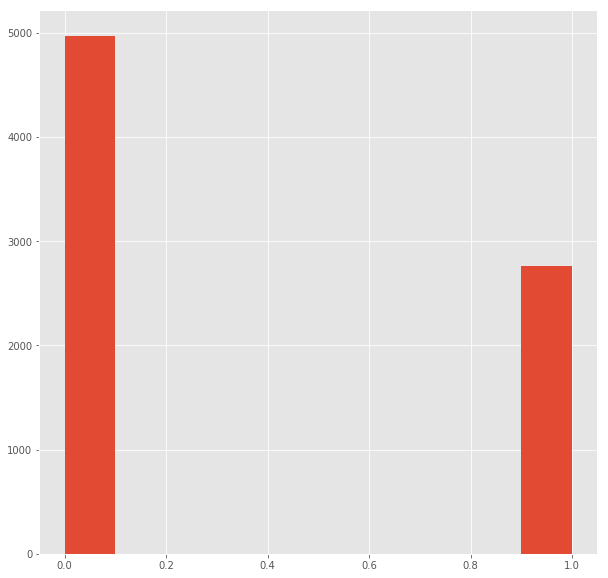

In [21]:
esito_5_nodi = clf_dt_5.predict(X_2)
plt.hist(esito_5_nodi)
plt.savefig("rf8.png")

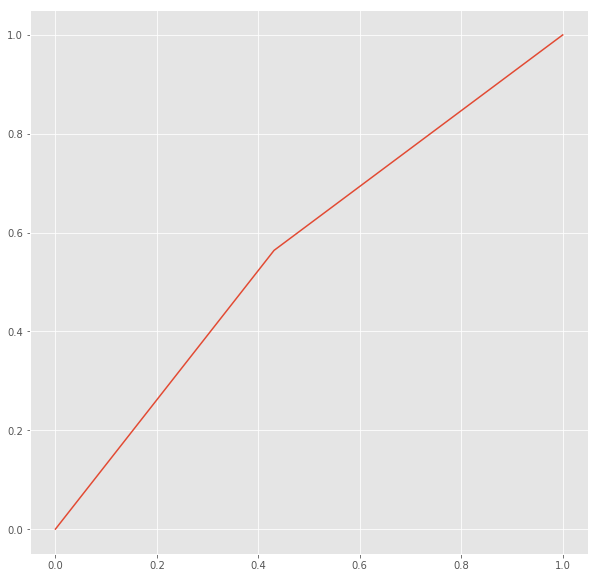

In [22]:
from sklearn.metrics import roc_curve

falsi_positivi, veri_positivi, _ = roc_curve(esito_5_nodi, df.estinto)
plt.plot(falsi_positivi, veri_positivi)
plt.savefig("rf9.png")

In [23]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(esito_5_nodi, df.estinto)
print(score)

0.566507160871


In [24]:
from sklearn.model_selection import StratifiedKFold

def cross_validation(dataset, classificatore, k):
    X = dataset.iloc[:,:-1]  # tutto tranne l'ultima colonna
    y = dataset.iloc[:,-1]  # solo l'ultima colonna ("estinto")
    
    kf = StratifiedKFold(n_splits=k)
    
    valori_aree = []

    for train_index, test_index in kf.split(X,y):
        X_training = X.iloc[train_index]
        y_training = y.iloc[train_index]
        classificatore = classificatore.fit(X_training, y_training)
        previsioni = classificatore.predict_proba(X.iloc[test_index])[:,1]
        area = roc_auc_score(y.iloc[test_index],previsioni)
        valori_aree.append(area)
    
    return np.mean(valori_aree)

In [25]:
dt = tree.DecisionTreeClassifier(max_depth=5)
dataset = df_encoded[['eta', 'saldo', 'estinto']]

print(cross_validation(dataset, dt, 5))

0.568803007679


In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)

print(cross_validation(df_encoded, rfc, 5))

0.699698753651


In [27]:
rfc = RandomForestClassifier(n_estimators=100)

print(cross_validation(df_encoded, rfc, 5))

0.740094531342


In [28]:
rfc = RandomForestClassifier(n_estimators=1000)

print(cross_validation(df_encoded, rfc, 5))

0.744262950021
